# ModTox: Predict toxicology towards CYP2C9 

1) Cluster a 250 nanoseconds molecular dynamics to extract 10 conformations of the receptor.

2) Dock a set of active/inactive compounds


3) Fit and predict a stack of 5 ML models to the resultant docking features.


4) Predict over the test set


5) Postprocess the result to retrieve the uncertanty of the predictions and the ROC, PR, and confusion matrix

In [1]:
!echo $PYTHONPATH
import os
import sys
os.environ["PYTHONPATH"]="/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/"
#sys.path.remove('/opt/AmberTools/amber16/lib/python2.7/site-packages')
print(sys.path)


/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/
['', '/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages', '/home/moruiz/anaconda3/envs/modtox_conda/lib/python36.zip', '/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6', '/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/lib-dynload', '/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/IPython/extensions', '/home/moruiz/.ipython']


In [38]:
import os
import glob
import numpy as np
import modtox.ML.preprocess as Pre
import modtox.ML.postprocess as Post
import modtox.ML.model2 as model
import modtox.docking.glide.analyse as gl
import modtox.data.pubchem as pchm
import modtox.data.dude as dd
import modtox.docking.glide.glide as dk
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!which python

/home/moruiz/anaconda3/envs/modtox_conda/bin/python


In [4]:
!echo $PYTHONPATH
import modtox.cpptraj.analisis as an


/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/


In [6]:
origin = '/home/moruiz/modtox_dir/modtox/'
main_folder = os.path.join(origin, 'test_jupyter')
os.path.abspath(main_folder)
if not os.path.exists(os.path.abspath(main_folder)): os.mkdir(main_folder)
os.chdir(main_folder)

In [8]:
os.getcwd()

'/home/moruiz/modtox_dir/modtox/test_jupyter'

## Cluster a Molecular dynamics simulation into 10 clusters

In [9]:
top = "/data/ModTox/5_CYPs/HROT_1r9o/1r9o_holo/1r9o_holo.top"
traj = "/data/ModTox/5_CYPs/HROT_1r9o/1r9o_holo/1R9O_*.x"
resname = "FLP"
output_dir = 'analysis'
an.analise(traj=traj, resname=resname, top=top, RMSD=True, cluster=True, last=True, clust_type="BS", rmsd_type="BS", sieve=10, output_dir=output_dir)

## Read active/inactives from DUD-E dataset and preparing files for train

In [11]:
dude = '/home/moruiz/cyp/dude/cp2c9/'
DBase = dd.DUDE(dude, train=True, test=False, debug=True)
sdf_active_train, sdf_inactive_train = DBase.process_dude()

6it [00:00, 55.51it/s]

Filter done


120it [00:02, 51.40it/s]
120it [00:02, 53.95it/s]


Files ./actives.sdf, ./inactives.sdf created with chembl curated compounds
Dude reading done!


## Read active/inactives from PubChem dataset and preparing files for test

In [12]:
pubchem = '/home/moruiz/cyp/pubchem/AID_1851_datatable_all.csv'
mol_to_read = 100
DBase = pchm.PubChem(pubchem, train=False, test=True, substrate = "p450-cyp2c9", n_molecules_to_read=mol_to_read, debug=True)
sdf_active_test, sdf_inactive_test = DBase.process_pubchem()

Reading from /home/moruiz/cyp/pubchem/AID_1851_datatable_all.csv


/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,7,9,10,12,13,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,96,97,98,99,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,120,121,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145) have mixed types. Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/moruiz/modtox_dir/modtox/modtox/data/pubchem.py:151: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  useful_activities = da

Label found
Discard of inconclusive essays done. Initial set: 100 , Final set: 58
Filter and inchikey identification in process ... for active


  0%|          | 0/37 [00:00<?, ?it/s]

Duplicates not detected
Assigning stereochemistry...


38it [00:38,  1.01s/it]                        
  0%|          | 0/20 [00:00<?, ?it/s]

Filter and inchikey identification in process ... for inactive


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Duplicates not detected


 32%|███▏      | 6/19 [00:00<00:00, 58.12it/s]

Active before cleaning: 38, after: 38
Inactive before cleaning: 20, after: 20
Assigning stereochemistry...


20it [00:18,  1.06it/s]                        


## Dock a dataset of active/inactive compounds

In [43]:
print(glob.glob(os.path.join(output_dir, "*clust*.pdb")))
docking_obj = dk.Glide_Docker(glob.glob(os.path.join(output_dir, "*clust*.pdb")), [sdf_active_train, sdf_inactive_train], debug=True)
docking_obj.dock(precision="SP", maxkeep=500, maxref=400, grid_mol=2)

['analysis/cluster.c0.pdb', 'analysis/cluster.c1.pdb', 'analysis/cluster.c2.pdb', 'analysis/cluster.c3.pdb', 'analysis/cluster.c4.pdb', 'analysis/cluster.c5.pdb', 'analysis/cluster.c6.pdb', 'analysis/cluster.c7.pdb', 'analysis/cluster.c8.pdb', 'analysis/cluster.c9.pdb']
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c0.pdb  -omae cluster.c0.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c1.pdb  -omae cluster.c1.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c2.pdb  -omae cluster.c2.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c3.pdb  -omae cluster.c3.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c4.pdb  -omae cluster.c4.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c5.pdb  -omae cluster.c5.mae
/opt/schrodinger2018-2/utilities/pdbconvert -ipdb analysis/cluster.c6.pdb  -omae cluster.c6.mae


KeyboardInterrupt: 

## Extracting features from glide docking

In [25]:
folder = "../tests_2/data/docking/"
inp_files = glob.glob(os.path.join(folder, "*dock_lib.maegz"))
print(inp_files)
csv = gl.analyze(inp_files, glide_dir=folder, best=False, csv=False, active=sdf_active_train, inactive=sdf_inactive_train, debug=True)
csv

['../tests_2/data/docking/input__cluster.c0__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c1__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c2__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c3__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c4__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c5__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c6__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c7__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c8__dock_lib.maegz', '../tests_2/data/docking/input__cluster.c9__dock_lib.maegz']
> /home/moruiz/modtox_dir/modtox/modtox/docking/glide/analyse.py(30)analyze()
-> results_merge = merge([glide_file], output=os.path.join(glide_dir,"results_merge_{}.mae".format(i)), debug=debug)
(Pdb) c
/opt/schrodinger2018-2/utilities/glide_merge ../tests_2/data/docking/input__cluster.c0__dock_lib.maegz -o ../tests_2/data/docking/results_merge_0.mae > /dev/null
/opt/schrodinger2018-2/u

'../tests_2/data/docking/glide_features.csv'

## Load active, inactives and docking data

Provide a sdf of active, a sdf with decoys and a csv with any external feature you want.
In this case, the external features will be the docking terms of glide docking over 10 different receptors

In [26]:
#folder = "tests_2/data/"
#sdf_active = os.path.join(folder, "actives.sdf")
#sdf_inactive = os.path.join(folder, "inactives.sdf")
#csv = os.path.join(folder, "glide_features.csv")

## Generate features, dropnans and filter unwanted columns

1) Generate features such as:

- MACCS fingerprints
- Daylight fingerprints
- Topological descriptors
- External csv with features

2) Sanitize: Drop all Nan samples (non docked)

3) Filter: Remove unwanted columns

In [27]:
pre = Pre.ProcessorSDF(csv=csv, fp=False, descriptors=False, MACCS=True, columns=None)
print("Fit and tranform for preprocessor..")
X, y = pre.fit_transform(sdf_active=sdf_active_train, sdf_inactive=sdf_inactive_train)
print("Sanitazing...")
pre.sanitize(X, y)
print("Filtering features...")
pre.filter_features(X)

Fit and tranform for preprocessor..
./actives.sdf ./inactives.sdf
Active, Inactive
120 120
Read Active, Read Inactive
120 120
Non Repited Active, Non Repited Inactive
120 120
Shape Dataset
240
	Building MACS Fingerprints
	Incorporating external data


/home/moruiz/modtox_dir/modtox/modtox/ML/external_descriptors.py:46: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = pd.concat([df.ix[:i-1], null_line, df.ix[i:]]).reset_index(drop=True)


[Pipeline] ....... (step 1 of 1) Processing transformer, total=  10.3s
Sanitazing...
Filtering features...


(array([[  0. ,   0. ,   0. , ..., -67. , -40.5,   9.8],
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ..., -59.6, -41.4,   8.4],
        ...,
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ..., -28.2, -30.5,  19.5]]),
 ['rdkit_fingerprintMACS_0',
  'rdkit_fingerprintMACS_1',
  'rdkit_fingerprintMACS_10',
  'rdkit_fingerprintMACS_100',
  'rdkit_fingerprintMACS_101',
  'rdkit_fingerprintMACS_102',
  'rdkit_fingerprintMACS_103',
  'rdkit_fingerprintMACS_104',
  'rdkit_fingerprintMACS_105',
  'rdkit_fingerprintMACS_106',
  'rdkit_fingerprintMACS_107',
  'rdkit_fingerprintMACS_108',
  'rdkit_fingerprintMACS_109',
  'rdkit_fingerprintMACS_11',
  'rdkit_fingerprintMACS_110',
  'rdkit_fingerprintMACS_111',
  'rdkit_fingerprintMACS_112',
  'rdkit_fingerprintMACS_113',
  'rdkit_fingerprintMACS_114',
  'rdkit_fingerprintMACS_115',
  'rdkit_fingerprintMACS_116'

## Fit  model

Choose between:

- A stack of 5 models (clf='stack')
- A single model optimized with tpot (clf='single')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#fit model
Model = model.GenericModel(clf='stack', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.910873440285205

Best pipeline: BernoulliNB(input_matrix, alpha=0.001, fit_prior=True)


Generation 1 - Current best internal CV score: 0.910873440285205

Best pipeline: GaussianNB(MaxAbsScaler(input_matrix))


Generation 1 - Current best internal CV score: 0.910873440285205

Best pipeline: GaussianNB(MinMaxScaler(input_matrix))


Generation 1 - Current best internal CV score: 0.904812834224599

Best pipeline: BernoulliNB(input_matrix, alpha=0.01, fit_prior=True)


Generation 1 - Current best internal CV score: 0.904812834224599

Best pipeline: BernoulliNB(input_matrix, alpha=0.1, fit_prior=False)


Generation 1 - Current best internal CV score: 0.9228163992869876

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=1, min_samples_leaf=9, min_samples_split=18)


In [30]:
#fit model
Model = model.GenericModel(clf='single', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.910873440285205
Generation 2 - Current best internal CV score: 0.910873440285205
Generation 3 - Current best internal CV score: 0.910873440285205
Generation 4 - Current best internal CV score: 0.910873440285205
Generation 5 - Current best internal CV score: 0.910873440285205
Generation 6 - Current best internal CV score: 0.910873440285205
Generation 7 - Current best internal CV score: 0.910873440285205
Generation 8 - Current best internal CV score: 0.910873440285205
Generation 9 - Current best internal CV score: 0.910873440285205
Generation 10 - Current best internal CV score: 0.910873440285205

Best pipeline: BernoulliNB(input_matrix, alpha=0.001, fit_prior=True)


## Predict on test

In [31]:
#predict model
print("Predicting...")
y_pred = Model.predict(X_test, y_test) 

Predicting...
Loading models


## Analyse results

Analyse results by checking:

1) Metrics

- ROC curve
- PR curve
- Confusion matrix

2) Feature Importance

- Shap Values (Permutation importance)
- XGboost (Gain relevance)

3) Uncertanties

- Distribution of train&test descriptors
- Applicability domain
- Majority voting

4) Dimensionality reduction

- UMAP
- TSNE
- PCA

In [32]:
pp = Post.PostProcessor('stack', x_test=Model.X_test_trans, y_true_test=Model.Y_test,
                        y_pred_test=Model.prediction_test, y_proba_test=Model.predictions_proba_test,
                        x_train=Model.X_trans, y_true_train=Model.Y)

### Metrics

In [33]:
ROC = pp.ROC()

In [34]:
PR = pp.PR()

Predicted   0   1
Actual           
0          37   0
1           7  28


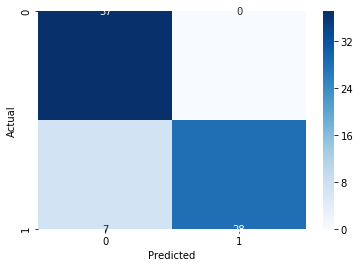

In [35]:
DA = pp.conf_matrix()

### Feature importance

/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/shap/plots/summary.py:56: UserWarning: auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.
  warnings.warn("auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.")


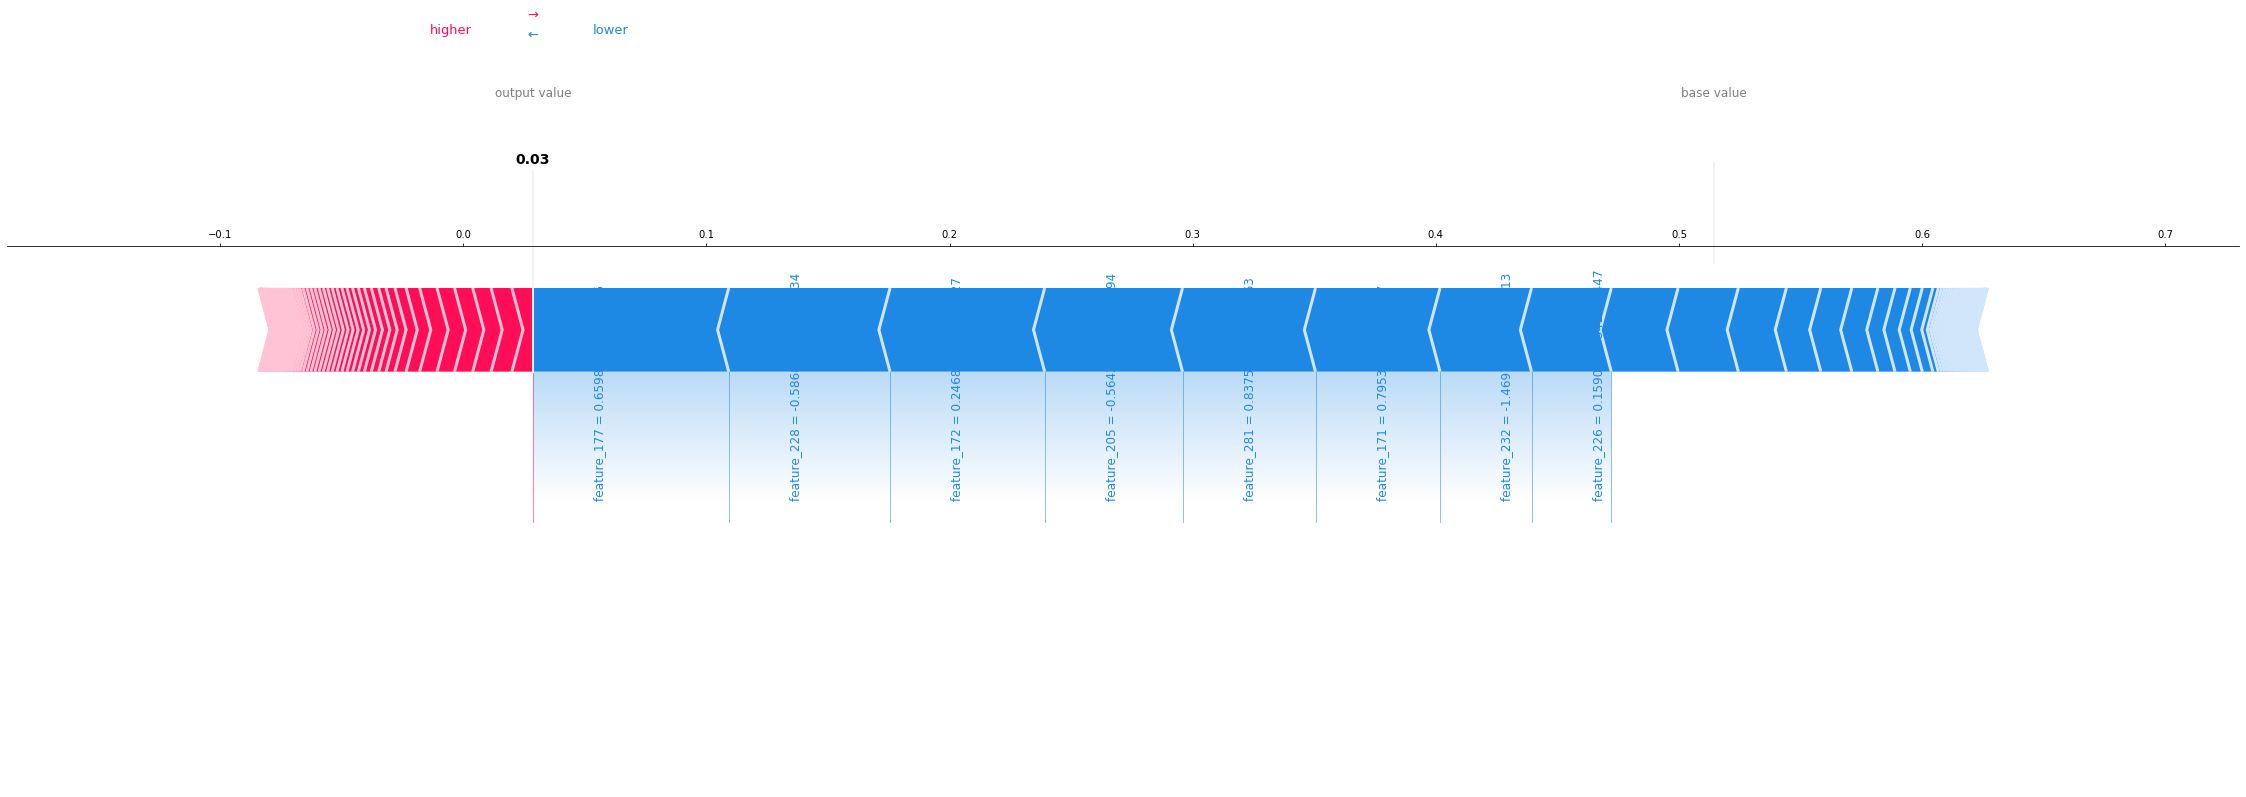

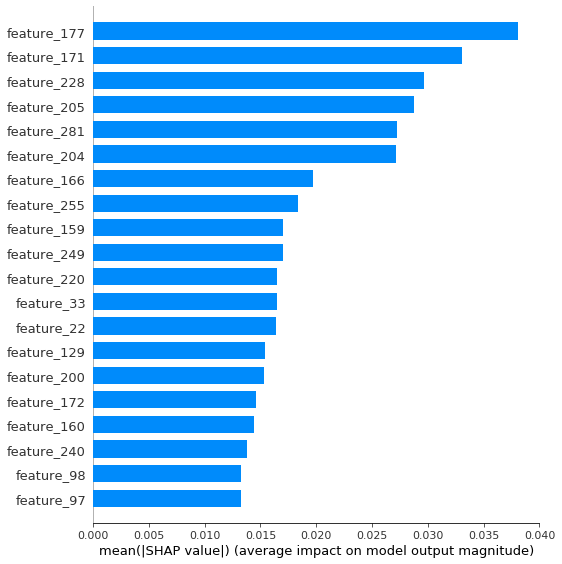

In [36]:
SH = pp.shap_values(debug=True)

In [19]:
FI = pp.feature_importance()

Extracting most importance features


### Uncertanties on predict

#### Descriptor distributions between test and train features.

In [20]:
DD = pp.distributions(debug=True)

  0%|          | 0/3 [00:00<?, ?it/s]/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


#### Applicability domain of test samples

In [21]:
DA = pp.domain_analysis()

  0%|          | 0/69 [00:00<?, ?it/s]

Computing applicability domains
Plotting


100%|██████████| 69/69 [00:17<00:00,  3.87it/s]


#### Uncertanty based on the results of the predictions of all classifiers

In [22]:
UN = pp.calculate_uncertanties()

TypeError: 'NoneType' object is not subscriptable

#### Dimensionanlity reduction

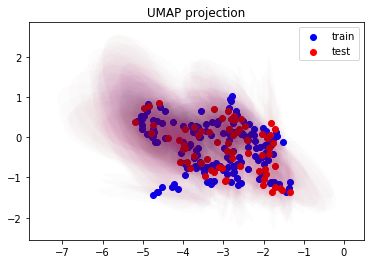

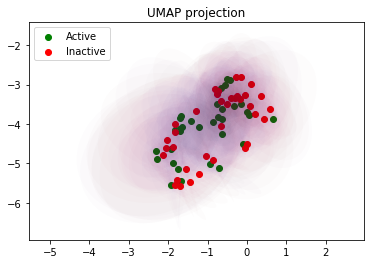

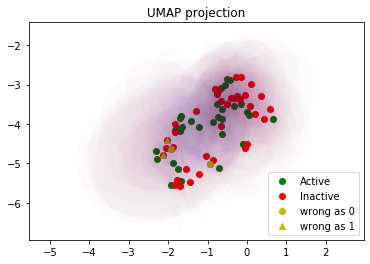

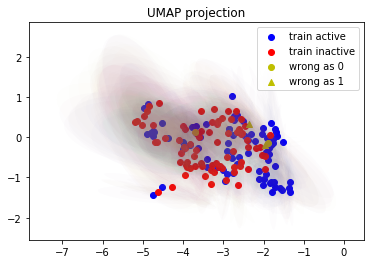

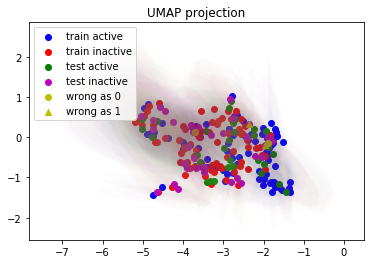

In [25]:
pp.UMAP_plot(single=True, wrong=True, wrongall=True, traintest=True, wrongsingle=True)

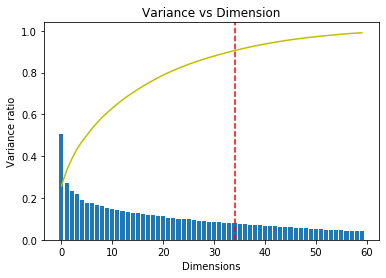

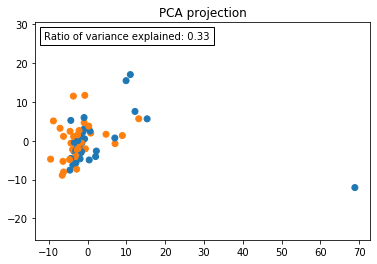

In [26]:
pp.PCA_plot()

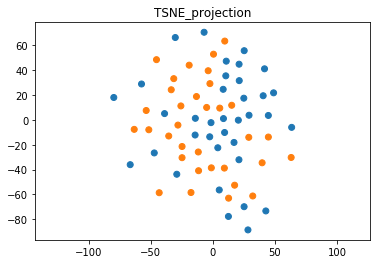

In [27]:
pp.tsne_plot()

# Use ModTox as API for your ML

In [29]:
 X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                 random_state=0)

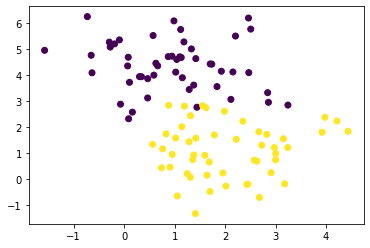

In [30]:
plt.scatter(X[:,0], X[:,1], c=y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
#fit model
Model = model.GenericModel(clf='single', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.9447619047619048
Generation 2 - Current best internal CV score: 0.9447619047619048
Generation 3 - Current best internal CV score: 0.9723809523809525
Generation 4 - Current best internal CV score: 0.9723809523809525
Generation 5 - Current best internal CV score: 0.9723809523809525
Generation 6 - Current best internal CV score: 0.9723809523809525
Generation 7 - Current best internal CV score: 0.9723809523809525
Generation 8 - Current best internal CV score: 0.9723809523809525
Generation 9 - Current best internal CV score: 0.9723809523809525
Generation 10 - Current best internal CV score: 0.9723809523809525

Best pipeline: BernoulliNB(CombineDFs(input_matrix, GaussianNB(input_matrix)), alpha=0.01, fit_prior=True)


/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [33]:
y_pred = Model.predict(X_test, y_test) 

Loading models


/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [34]:
y_pred

[True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [35]:
pp = Post.PostProcessor('single', x_test=Model.X_test_trans, y_true_test=Model.Y_test,
                        y_pred_test=Model.prediction_test, y_proba_test=Model.predictions_proba_test,
                        x_train=Model.X_trans, y_true_train=Model.Y)

In [36]:
ROC = pp.ROC()

In [37]:
PR = pp.PR()

Predicted   0   1
Actual           
0          11   0
1           2  17


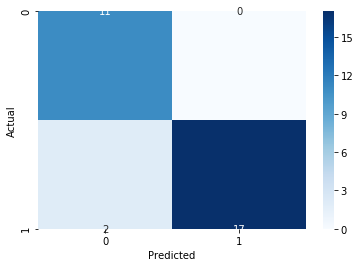

In [38]:
DA = pp.conf_matrix()

/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
  0%|          | 0/1 [00:00<?, ?it/s]/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/shap/plots/force_matplotlib.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)
100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
/home/moruiz/anaconda3/envs/modtox_conda/lib/python3.6/site-packages/shap/plots/summary.py:56: UserWarning: auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.
  warnings.warn("auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.")


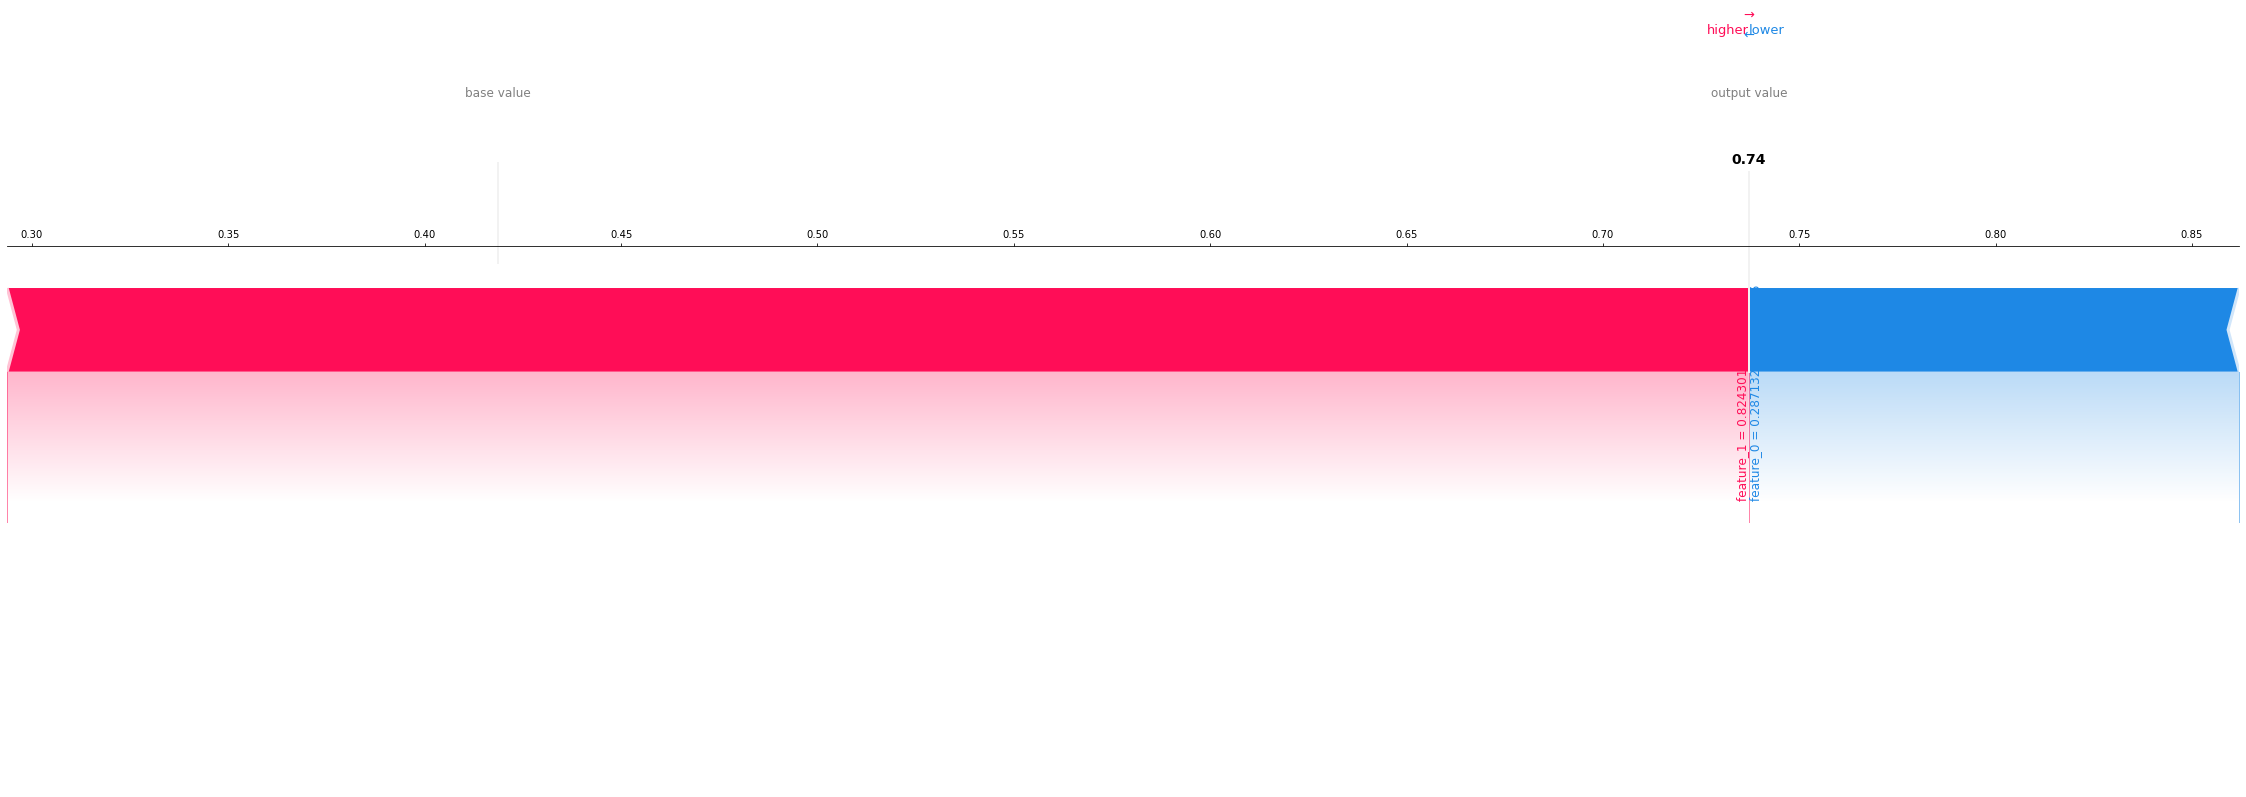

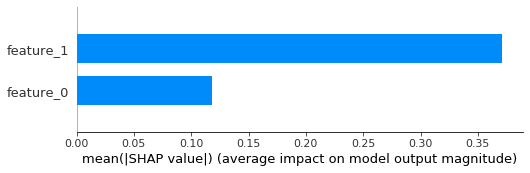

In [39]:
SH = pp.shap_values(debug=True)

In [40]:
FI = pp.feature_importance()

Extracting most importance features


In [41]:
DA = pp.domain_analysis()

  0%|          | 0/30 [00:00<?, ?it/s]

Computing applicability domains
Plotting


100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


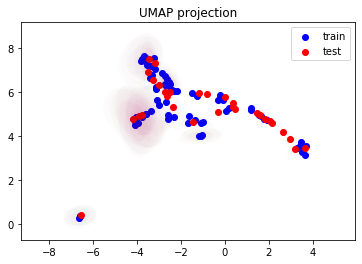

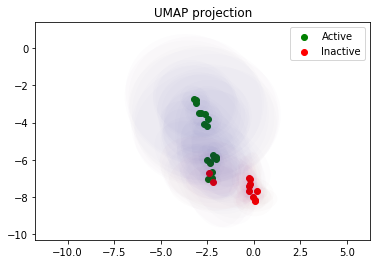

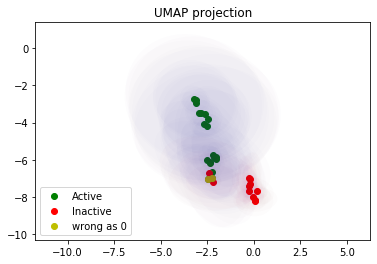

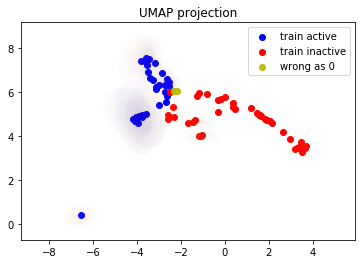

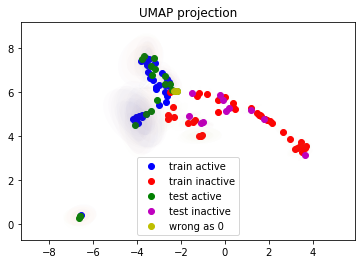

In [44]:
pp.UMAP_plot(single=True, wrong=True, wrongall=True, traintest=True, wrongsingle=True)

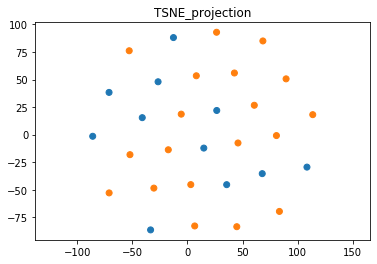

In [45]:
pp.tsne_plot()

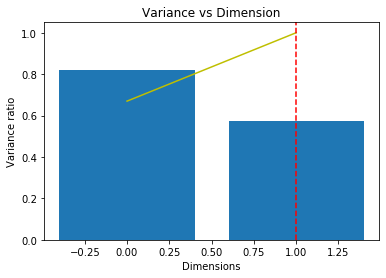

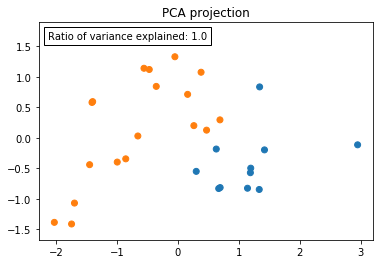

In [46]:
pp.PCA_plot()